In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
from scipy.special import expit

1. Data Generation (i.i.d. Assumption)

In [2]:
def generate_data(n_samples, n_features=10, random_state=42):
    X, y = make_classification(
        n_samples=n_samples, 
        n_features=n_features, 
        n_informative=5, 
        n_redundant=0, 
        random_state=random_state,
        class_sep=1.0
    )
    y = 2 * y - 1 
    return X, y


2. Loss & Gradient Functions (Convex)

In [3]:
def logistic_loss(z, y):
    return np.log(1 + np.exp(-y * z))

def logistic_gradient(x, feature_vec, y):
    margin = y * np.dot(x, feature_vec)
    sigmoid_val = expit(-margin) 
    return -y * feature_vec * sigmoid_val

3. Online Learning Algorithm (OGD)

In [4]:
class OnlineLogisticRegressor:
    def __init__(self, n_features, eta_base=1.0):
        self.n_features = n_features
        self.eta_base = eta_base
        self.iterates = []
        
    def fit(self, X, y):
        x = np.zeros(self.n_features)
        self.iterates.append(x.copy())
        
        T = len(y)
        for t in range(T):
            eta = self.eta_base / np.sqrt(t + 1)
            grad = logistic_gradient(x, X[t], y[t])
            x = x - eta * grad
            self.iterates.append(x.copy())
            
        return self

    def get_averaged_predictor(self):
        return np.mean(self.iterates[:-1], axis=0)

    def get_last_predictor(self):
        return self.iterates[-1]


4. Evaluation Metrics

In [5]:
def compute_risk(x, X, y):
    margins = y * X.dot(x)
    losses = np.log(1 + np.exp(-margins))
    return np.mean(losses)

def compute_regret_curve(online_model, X, y):
    erm = LogisticRegression(penalty=None, solver='lbfgs', max_iter=1000)
    erm.fit(X, (y + 1) / 2)
    u = erm.coef_.flatten()
    
    regrets = []
    cum_loss_alg = 0
    cum_loss_u = 0
    
    for t in range(len(y)):
        x_t = online_model.iterates[t] 
        loss_alg = logistic_loss(np.dot(x_t, X[t]), y[t])
        loss_u = logistic_loss(np.dot(u, X[t]), y[t])
        
        cum_loss_alg += loss_alg
        cum_loss_u += loss_u
        regrets.append(cum_loss_alg - cum_loss_u)
        
    return regrets


5. Main Experiment

In [6]:
def run_experiment():
    T_max = 1000
    n_features = 10
    n_test = 500
    
    X_full, y_full = generate_data(n_samples=T_max + n_test, n_features=n_features)
    X_train, y_train = X_full[:T_max], y_full[:T_max]
    X_test, y_test = X_full[T_max:], y_full[T_max:]
    
    online_model = OnlineLogisticRegressor(n_features=n_features, eta_base=1.0)
    online_model.fit(X_train, y_train)
    
    x_avg = online_model.get_averaged_predictor()
    x_last = online_model.get_last_predictor()
    
    erm_risks = []
    avg_risks = []
    last_risks = []
    test_risks_erm = []
    test_risks_avg = []
    
    checkpoints = [10, 50, 100, 200, 500, 1000]
    
    for t in checkpoints:
        if t > T_max: break
        
        erm = LogisticRegression(penalty=None, solver='lbfgs', max_iter=1000)
        erm.fit(X_train[:t], (y_train[:t] + 1) / 2)
        x_erm = erm.coef_.flatten()
        
        risk_erm = compute_risk(x_erm, X_train[:t], y_train[:t])
        risk_avg = compute_risk(x_avg, X_train[:t], y_train[:t])
        
        x_avg_t = np.mean(online_model.iterates[1:t+1], axis=0) 
        risk_avg_t = compute_risk(x_avg_t, X_train[:t], y_train[:t])
        risk_last_t = compute_risk(online_model.iterates[t], X_train[:t], y_train[:t])
        
        test_erm = compute_risk(x_erm, X_test, y_test)
        test_avg = compute_risk(x_avg_t, X_test, y_test)
        
        erm_risks.append(risk_erm)
        avg_risks.append(risk_avg_t)
        last_risks.append(risk_last_t)
        test_risks_erm.append(test_erm)
        test_risks_avg.append(test_avg)

    regrets = compute_regret_curve(online_model, X_train, y_train)
    
    return checkpoints, erm_risks, avg_risks, last_risks, test_risks_erm, test_risks_avg, regrets


checkpoints, erm_risks, avg_risks, last_risks, test_risks_erm, test_risks_avg, regrets = run_experiment()


d:\Users\kju10\Documents\LMU-STATISTICS & DATA SCIENCE MASTER\WS2526\Seminar\implementation\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
d:\Users\kju10\Documents\LMU-STATISTICS & DATA SCIENCE MASTER\WS2526\Seminar\implementation\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
d:\Users\kju10\Documents\LMU-STATISTICS & DATA SCIENCE MASTER\

6. Plotting Results

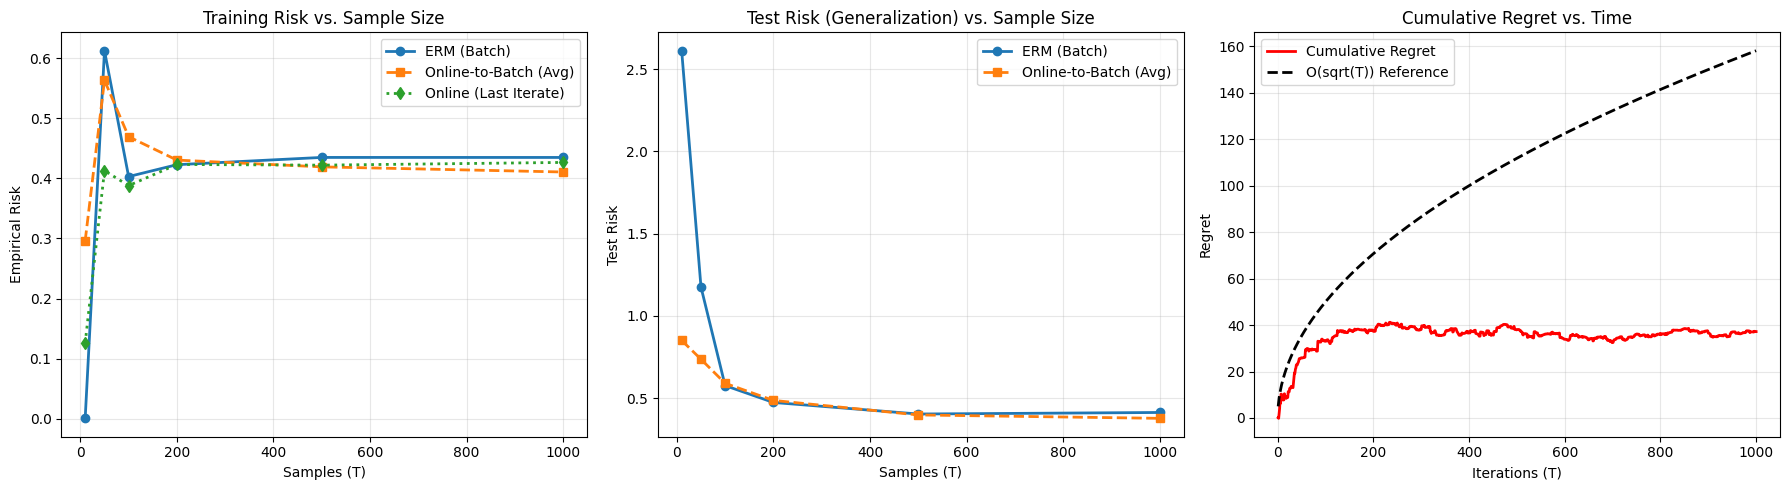

Final Training Risk (ERM): 0.4349
Final Training Risk (Online Avg): 0.4107
Final Test Risk (ERM): 0.4131
Final Test Risk (Online Avg): 0.3774


In [29]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Training Risk Convergence (Empirical Risk)
axs[0].plot(checkpoints, erm_risks, 'o-', label='ERM (Batch)', linewidth=2)
axs[0].plot(checkpoints, avg_risks, 's--', label='Online-to-Batch (Avg)', linewidth=2)
axs[0].plot(checkpoints, last_risks, 'd:', label='Online (Last Iterate)', linewidth=2)
axs[0].set_title('Training Risk vs. Sample Size', fontsize=12)
axs[0].set_xlabel('Samples (T)')
axs[0].set_ylabel('Empirical Risk')
axs[0].legend()
axs[0].grid(True, alpha=0.3)

# Plot 2: Generalization (Test Risk)
axs[1].plot(checkpoints, test_risks_erm, 'o-', label='ERM (Batch)', linewidth=2)
axs[1].plot(checkpoints, test_risks_avg, 's--', label='Online-to-Batch (Avg)', linewidth=2)
axs[1].set_title('Test Risk (Generalization) vs. Sample Size', fontsize=12)
axs[1].set_xlabel('Samples (T)')
axs[1].set_ylabel('Test Risk')
axs[1].legend()
axs[1].grid(True, alpha=0.3)

# Plot 3: Regret Growth
axs[2].plot(range(1, len(regrets)+1), regrets, 'r-', label='Cumulative Regret', linewidth=2)
# Plot sqrt(T) reference line
t_vals = np.arange(1, len(regrets)+1)
axs[2].plot(t_vals, 5 * np.sqrt(t_vals), 'k--', label='O(sqrt(T)) Reference', linewidth=2)
axs[2].set_title('Cumulative Regret vs. Time', fontsize=12)
axs[2].set_xlabel('Iterations (T)')
axs[2].set_ylabel('Regret')
axs[2].legend()
axs[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print Final Comparison
print(f"Final Training Risk (ERM): {erm_risks[-1]:.4f}")
print(f"Final Training Risk (Online Avg): {avg_risks[-1]:.4f}")
print(f"Final Test Risk (ERM): {test_risks_erm[-1]:.4f}")
print(f"Final Test Risk (Online Avg): {test_risks_avg[-1]:.4f}")
